## Preprocess pan-cancer 450K methylation data

Load the downloaded data and curate sample IDs.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg

### Load and process methylation data

In [2]:
# first load manifest file, this tells us the filenames of the raw data files
manifest_df = pd.read_csv(os.path.join(cfg.data_dir, 'manifest.tsv'),
                          sep='\t', index_col=0)
manifest_df.head(3)

,id,filename,md5,size
name,,,,
mirna_sample,55d9bf6f-0712-4315-b588-e6f8e295018e,PanCanAtlas_miRNA_sample_information_list.txt,02bb56712be34bcd58c50d90387aebde,553408
methylation_27k,d82e2c44-89eb-43d9-b6d3-712732bf6a53,jhu-usc.edu_PANCAN_merged_HumanMethylation27_H...,5cec086f0b002d17befef76a3241e73b,5022150019
methylation_450k,99b0c493-9e94-4d99-af9f-151e46bab989,jhu-usc.edu_PANCAN_HumanMethylation450.betaVal...,a92f50490cf4eca98b0d19e10927de9d,41541692788


In [3]:
# this is much faster than loading directly from .tsv
# useful if you need to run this preprocessing script multiple times
methylation_pickle = os.path.join(cfg.data_dir, 'methylation_450k.pkl')

if os.path.isfile(methylation_pickle):
    print('loading from pickle')
    tcga_methylation_df = pd.read_pickle(methylation_pickle)
else:
    tcga_methylation_df = (
        pd.read_csv(os.path.join(cfg.raw_data_dir,
                                 manifest_df.loc['methylation_450k'].filename),
                    index_col=0,
                    sep='\t',
                    dtype='float32', # float64 won't fit in 64GB RAM
                    converters={0: str}) # don't convert the col names to float
           .transpose()
    )

tcga_methylation_df.index.rename('sample_id', inplace=True)

print(tcga_methylation_df.shape)
tcga_methylation_df.iloc[:5, :5]

loading from pickle
(9664, 396065)


,cg00000029,cg00000165,cg00000236,cg00000289,cg00000292
sample_id,,,,,
TCGA-OR-A5J1-01A-11D-A29J-05,0.119877,0.903200,0.879704,0.766316,0.409997
TCGA-OR-A5J2-01A-11D-A29J-05,0.107120,0.818523,0.256479,0.674323,0.552000
TCGA-OR-A5J3-01A-11D-A29J-05,0.060752,0.093014,0.253639,0.750682,0.851327
TCGA-OR-A5J4-01A-11D-A29J-05,0.157005,0.856304,0.940341,0.842987,0.847317
TCGA-OR-A5J5-01A-11D-A29J-05,0.534426,0.928812,0.931214,0.766848,0.761502


In [4]:
if os.path.isfile(methylation_pickle):
    print('pickle already exists')
else:
    print('saving df to pickle')
    tcga_methylation_df.to_pickle(methylation_pickle)

pickle already exists


In [5]:
# update sample IDs to remove multiple samples measured on the same tumor
# and to map with the clinical information
tcga_methylation_df.index = tcga_methylation_df.index.str.slice(start=0, stop=15)
tcga_methylation_df = tcga_methylation_df.loc[~tcga_methylation_df.index.duplicated(), :]
print(tcga_methylation_df.shape)

(9639, 396065)


In [6]:
# how many missing values does each probe (column) have?
sample_na = tcga_methylation_df.transpose().isna().sum()
print(sample_na.shape)
sample_na.sort_values(ascending=False).head()

(9639,)


sample_id
TCGA-FG-5962-01    10500
TCGA-67-4679-01    10043
TCGA-EL-A4JX-01     7675
TCGA-2J-AABR-01     7562
TCGA-W5-AA2Q-01     7505
dtype: int64

In [7]:
# remove 10 samples with most NAs, then impute for probes with 1 or 2 NA values
n_filter = 10
n_impute = 5

samples_sorted = sample_na.sort_values(ascending=False)
output_dir = os.path.join(cfg.data_dir, 'methylation_preprocessed')
os.makedirs(output_dir, exist_ok=True)

def filter_na_samples(methylation_df, bad_samples):
    # don't drop NA columns, we'll do that after imputation
    return (
        methylation_df.loc[~methylation_df.index.isin(bad_samples)]
    )

def impute_leq(methylation_df, n_na):
    if n_na == 0:
        return methylation_df
    else:
        return methylation_df.fillna(methylation_df.mean(), limit=n_na)

# filter, impute, drop NA columns
print(tcga_methylation_df.shape)
samples_for_count = samples_sorted.iloc[:n_filter].index.values
tcga_methylation_df = filter_na_samples(tcga_methylation_df,
                                        samples_for_count)
print(tcga_methylation_df.shape)
tcga_methylation_df = impute_leq(tcga_methylation_df, n_impute)
tcga_methylation_df.dropna(axis='columns', inplace=True)
print(tcga_methylation_df.shape)

(9639, 396065)
(9629, 396065)
(9629, 370961)


### Dimension reduction

Since we can't realistically fit a logistic regression model to 300K features, compress the data using PCA with various dimensions, and save the results to tsv files.

Note that it's much faster to calculate this once for the largest dimensionality, then truncate it, than to recalculate the PCA for each number of PCs. However, using the sklearn PCA implementation, the results are actually slightly different for these two approaches (particularly for smaller PCs), since it uses a randomized thin SVD algorithm by default rather than calculating the exact SVD. 

I created [this issue](https://github.com/greenelab/mpmp/issues/15) to investigate/remind myself of this instability in the future, but I don't think it'll matter that much in practice.

In [8]:
from sklearn.decomposition import PCA

pca_dir = os.path.join(cfg.data_dir, 'me_compressed')
os.makedirs(pca_dir, exist_ok=True)

n_pcs_list = [100, 1000, 5000]

# it's much faster to just calculate this once for max n_pcs, and truncate it,
# than to recalculated it for each number of PCs we want
pca = PCA(n_components=max(n_pcs_list))
me_pca = pca.fit_transform(tcga_methylation_df)
print(me_pca.shape)

for n_pcs in n_pcs_list:
    me_pca_truncated = pd.DataFrame(me_pca[:, :n_pcs], index=tcga_methylation_df.index)
    print(me_pca_truncated.shape)
    me_pca_truncated.to_csv(
        os.path.join(pca_dir, 'me_450k_f{}_i{}_pc{}.tsv.gz'.format(
                         n_filter, n_impute, n_pcs)),
        sep='\t',
        float_format='%.3g')

(9629, 5000)


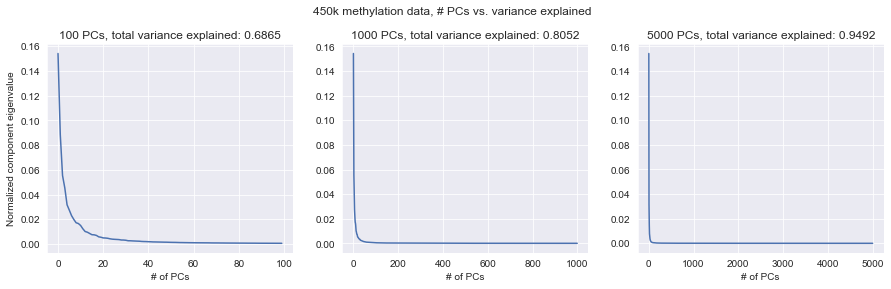

In [9]:
# plot PCA variance explained
import matplotlib.pyplot as plt
import seaborn as sns

sns.set({'figure.figsize': (15, 4)})
fig, axarr = plt.subplots(1, 3)

for ix, n_pcs in enumerate(n_pcs_list):
    ve = pca.explained_variance_ratio_[:n_pcs]
    sns.lineplot(x=range(n_pcs), y=ve, ax=axarr[ix])
    axarr[ix].set_title('{} PCs, total variance explained: {:.4f}'.format(
        n_pcs_list[ix], sum(ve, 0)))
    axarr[ix].set_xlabel('# of PCs')
    if ix == 0:
        axarr[ix].set_ylabel('Normalized component eigenvalue')
plt.suptitle('450k methylation data, # PCs vs. variance explained')
plt.subplots_adjust(top=0.85)